In [112]:
import pickle
import pandas as pd
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [113]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('ggplot')


In [114]:
current_dir = Path('.')
save_location = Path(r'F:\\From_D_drive\\GD_material\\Control_mechanism_2024\\')
save_location

WindowsPath('F:/From_D_drive/GD_material/Control_mechanism_2024')

In [115]:
# for reading
with open(current_dir.absolute() / 'data_ML_all.pickle', 'rb') as file:
    data_ML_all = pickle.load(file)

In [116]:
data_ML_all.keys()

dict_keys(['R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25'])

In [117]:
data_ML_all['R_3'].describe()

,rotor_posn,stator_exc_0,stator_exc_U,stator_exc_D,torque_rotor
count,31768.000000,31768.000000,31768.000000,31768.000000,31768.000000
mean,-0.000083,79.560729,88.357030,87.470732,1.460261
std,0.349880,1153.600326,1151.604232,1153.284995,37.083229
min,-0.594242,-1999.880153,-1999.973913,-1999.933055,-137.546823
25%,-0.303333,-931.300874,-906.849343,-908.014502,-18.091421
50%,0.011818,147.899544,164.465875,159.981105,0.300000
75%,0.302727,1080.496567,1079.820876,1079.285289,20.114118
max,0.593636,1999.865153,1999.987138,1999.881048,154.046693


In [118]:
rotor = 'R_3'

rotor_data = data_ML_all[rotor]
X_features = rotor_data.drop('torque_rotor', axis=1)
target = rotor_data['torque_rotor']

## StandardScaler

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

X_features_scaled = pd.DataFrame(X_features_scaled, index=X_features.index, columns=X_features.columns)


# Decision Tree

In [120]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [121]:

X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, target, test_size=0.2, random_state=42)

In [122]:
regr = LinearTreeRegressor(base_estimator=LinearRegression())
regr.fit(X_train, y_train)

LinearTreeRegressor(base_estimator=LinearRegression())

In [123]:
y_pred = regr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('\n*** TEST ***')
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')


*** TEST ***
R2: 0.8810905988678401
MSE: 171.3791956360774
MAE: 9.587155831116924


In [124]:
X_features_scaled.columns

Index(['rotor_posn', 'stator_exc_0', 'stator_exc_U', 'stator_exc_D'], dtype='object')

In [125]:
regr.feature_importances_


array([0.79901691, 0.17276935, 0.02821374, 0.        ])

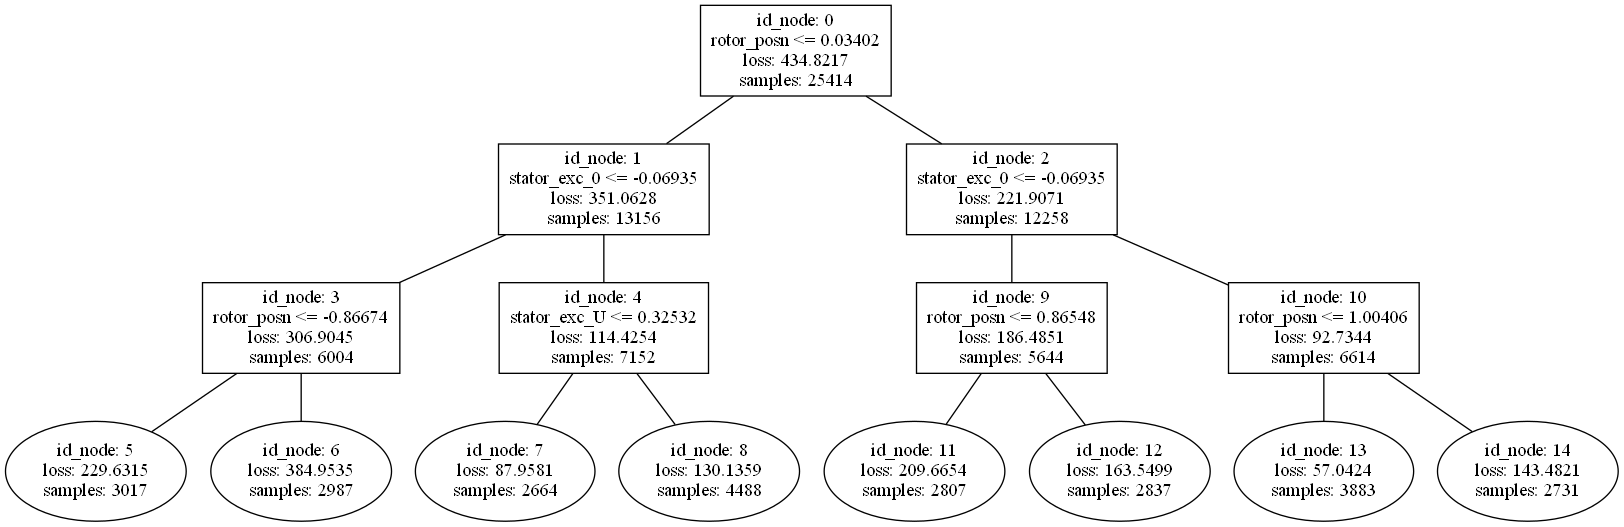

In [126]:
regr.plot_model(feature_names = list(X_features_scaled.columns))


In [127]:
tree_summary = regr.summary(feature_names = list(X_features_scaled.columns))
tree_summary

{0: {'col': 'rotor_posn',
  'th': 0.03402,
  'loss': 434.82166,
  'samples': 25414,
  'children': (1, 2),
  'models': (LinearRegression(), LinearRegression())},
 1: {'col': 'stator_exc_0',
  'th': -0.06935,
  'loss': 351.0628,
  'samples': 13156,
  'children': (3, 4),
  'models': (LinearRegression(), LinearRegression())},
 2: {'col': 'stator_exc_0',
  'th': -0.06935,
  'loss': 221.90711,
  'samples': 12258,
  'children': (9, 10),
  'models': (LinearRegression(), LinearRegression())},
 3: {'col': 'rotor_posn',
  'th': -0.86674,
  'loss': 306.90446,
  'samples': 6004,
  'children': (5, 6),
  'models': (LinearRegression(), LinearRegression())},
 4: {'col': 'stator_exc_U',
  'th': 0.32532,
  'loss': 114.42538,
  'samples': 7152,
  'children': (7, 8),
  'models': (LinearRegression(), LinearRegression())},
 9: {'col': 'rotor_posn',
  'th': 0.86548,
  'loss': 186.48511,
  'samples': 5644,
  'children': (11, 12),
  'models': (LinearRegression(), LinearRegression())},
 10: {'col': 'rotor_posn',

In [128]:
X_train.describe()

,rotor_posn,stator_exc_0,stator_exc_U,stator_exc_D
count,25414.000000,25414.000000,25414.000000,25414.000000
mean,0.002439,0.004166,-0.003723,0.001095
std,1.000250,1.000257,1.001539,1.001630
min,-1.698205,-1.802595,-1.813145,-1.809992
25%,-0.866739,-0.868993,-0.875764,-0.862723
50%,0.034016,0.062046,0.064410,0.060846
75%,0.865483,0.872975,0.860644,0.866448
max,1.696949,1.664645,1.659765,1.658255


## Splines

* Extracxt all the nodes
* Put all the noides in a dictionary
* Generate splines using these nodes
* For single node crteate piecewise linear plot
* For two nodes create Quadratic splines

In [129]:
threshold_dict = {}
feats_names_list = list(X_train.columns)

for decision_node in regr._leaves.values():
    # print(decision_node.threshold)

    for ele in decision_node.threshold:
        # print(ele[0], ele[2])
        if ele[0] in threshold_dict:
            threshold_dict[ele[0]].append(ele[2])
        else:
            threshold_dict[ele[0]] = [ele[2]]


threshold_dict = {feats_names_list[k] : list(set(v)) for k, v in threshold_dict.items()}
threshold_dict

{'rotor_posn': [0.03401628136634827,
  -0.86673903465271,
  0.8654826879501343,
  1.0040603876113892],
 'stator_exc_0': [-0.06934672594070435],
 'stator_exc_U': [0.32531552761793114]}

For:
* rotor_posn : 4 boundaries
* stator_exc_0 : 1 boundary
* stator_exc_U : 1 boundary

In [130]:
from pygam import LinearGAM, s, l

In [131]:
knots['rotor_posn']

[0.03401628136634827,
 -0.86673903465271,
 0.8654826879501343,
 1.0040603876113892]

In [132]:
from patsy import dmatrix
import statsmodels.api as sm

knots = threshold_dict

transformed_x = pd.DataFrame()

linear_features = [col for col in X_train.columns if col not in knots.keys()]

for feature in linear_features:
    transformed_x[feature] = X_train[feature]

for key, knot in knots.items():
    # degree = 3 if len(knot) > 2 else 1
    degree = 3
    temp = dmatrix(f"bs({key}, knots={knot}, degree={degree}, include_intercept=False)",
                  {f"{key}" : X_train[key]},
                  return_type="dataframe"
                  )
    transformed_x = pd.concat([transformed_x, temp], axis=1)

gam = sm.GLM(y_train, transformed_x).fit()

In [133]:
gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           torque_rotor   No. Observations:                25414
Model:                            GLM   Df Residuals:                    25397
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                          1121.3
Method:                          IRLS   Log-Likelihood:            -1.2528e+05
Date:                Wed, 12 Jun 2024   Deviance:                   2.8478e+07
Time:                        15:15:23   Pearson chi2:                 2.85e+07
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1912
Covariance Type:            nonrobust                                         
================================================================================================================================================================================================================
                                                                                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
stator_exc_D                                                                                                                                     0.5963      0.254      2.352      0.019       0.099       1.093
Intercept                                                                                                                                        3.6011      0.604      5.957      0.000       2.416       4.786
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[0]    33.0744      2.196     15.062      0.000      28.771      37.378
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[1]   -31.3680      1.595    -19.665      0.000     -34.494     -28.242
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[2]    -9.1344      1.937     -4.716      0.000     -12.931      -5.338
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[3]    52.7342      1.530     34.465      0.000      49.735      55.733
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[4]   -18.8875      1.878    -10.057      0.000     -22.568     -15.207
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[5]    10.4407      2.350      4.443      0.000       5.835      15.047
bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[6]     1.0379      1.699      0.611      0.541      -2.292       4.367
Intercept                                                                                                                                        3.6011      0.604      5.957      0.000       2.416       4.786
bs(stator_exc_0, knots=[-0.06934672594070435], degree=3, include_intercept=False)[0]                                                             5.0722      2.135      2.376      0.018       0.888       9.257
bs(stator_exc_0, knots=[-0.06934672594070435], degree=3, include_intercept=False)[1]                                                             0.3138      

In [134]:
transformed_x_test = pd.DataFrame()

for feature in linear_features:
    transformed_x_test[feature] = X_test[feature]

for key, knot in knots.items():
    # degree = 3 if len(knot) > 2 else 1
    degree = 3
    temp = dmatrix(f"bs({key}, knots={knot}, degree={degree}, include_intercept=False)",
                  {f"{key}" : X_test[key]},
                  return_type="dataframe"
                  )
    transformed_x_test = pd.concat([transformed_x_test, temp], axis=1)

y_pred = gam.predict(transformed_x_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('\n*** TEST ***')
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')


*** TEST ***
R2: 0.19628306895956638
MSE: 1158.3639295913786
MAE: 26.991567992973597


### Plots

In [135]:
X_train.columns

Index(['rotor_posn', 'stator_exc_0', 'stator_exc_U', 'stator_exc_D'], dtype='object')

In [136]:
gam.params.keys()

Index(['stator_exc_D', 'Intercept',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[0]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[1]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[2]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[3]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[4]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.86673903465271, 0.8654826879501343, 1.0040603876113892], degree=3, include_intercept=False)[5]',
       'bs(rotor_posn, knots=[0.03401628136634827, -0.8667

In [142]:
import numpy as np

(25414, 7)
	 33.074401371281695
	 -31.368017820595025
	 -9.134410439426917
	 52.734226166632986
	 -18.887545838610293
	 10.440682819695308
	 1.0378874360536419


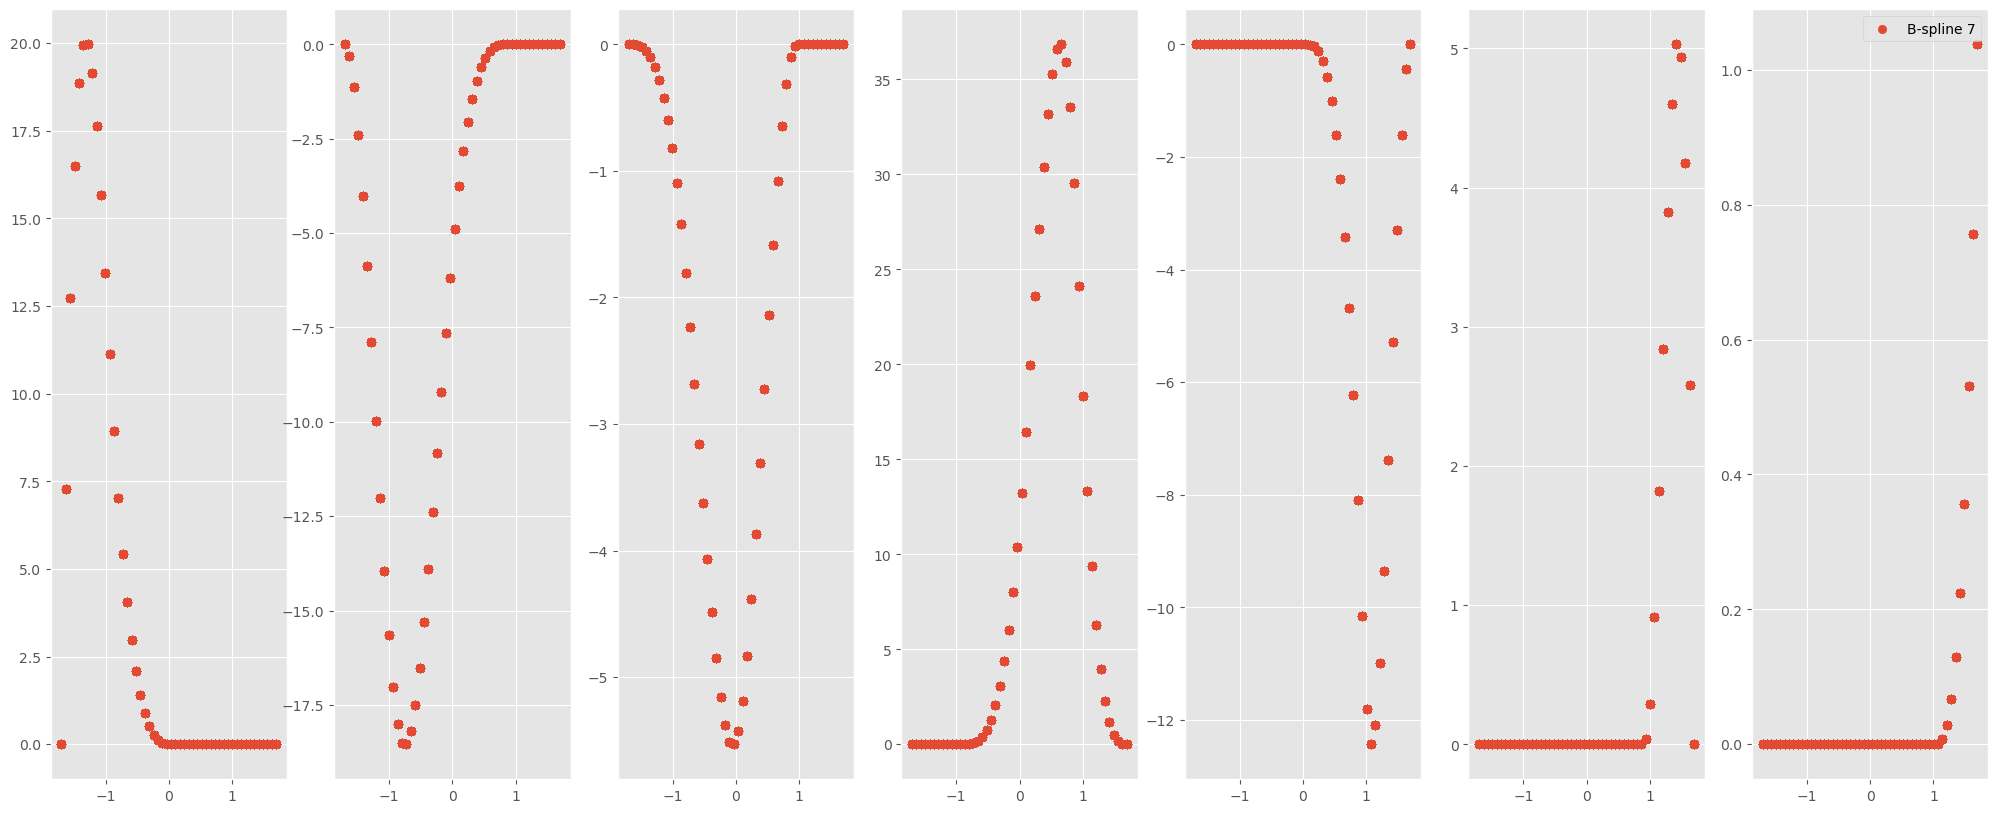

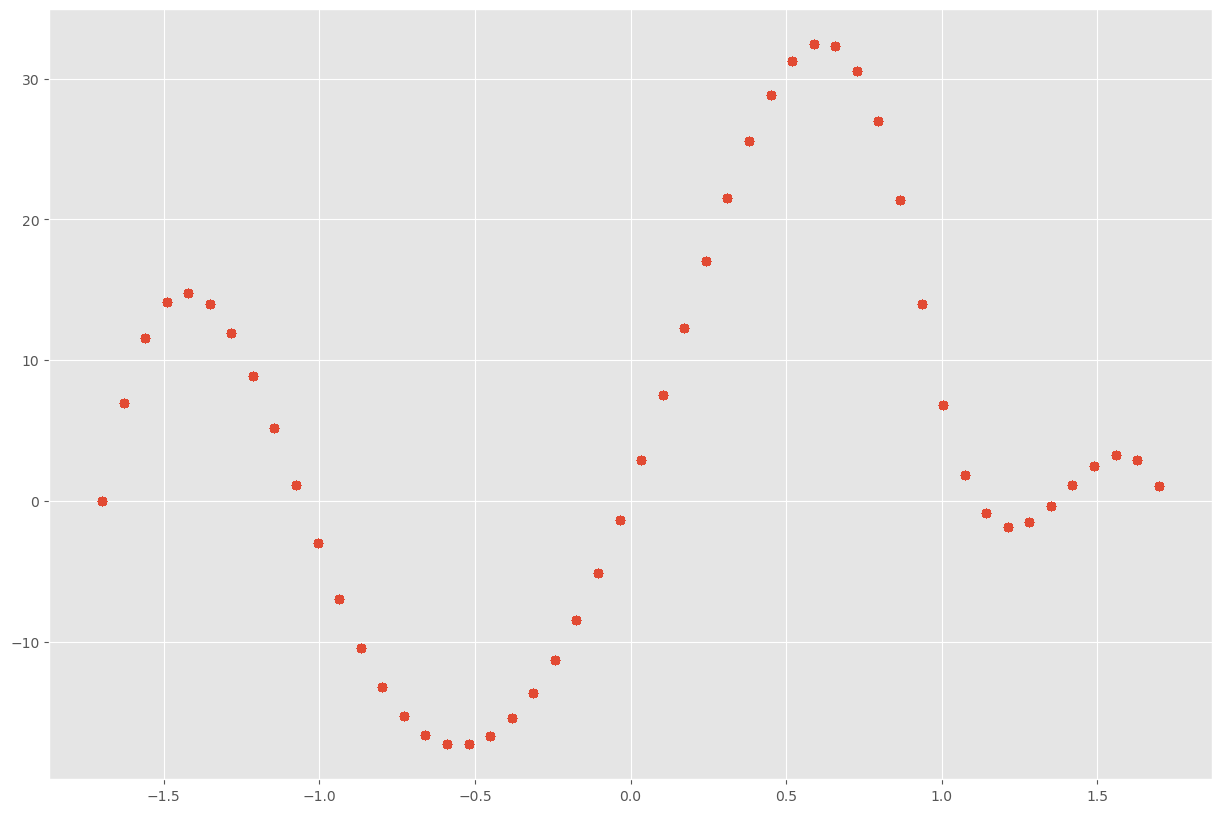

In [143]:
feature = 'rotor_posn'
x = X_train[feature]

degree = 3
df_feature = dmatrix(f"bs(x, knots={knots[feature]}, degree={degree}, include_intercept=False) - 1",
                     {"x" : x}, return_type="dataframe")

params = []
bs_cols = [col for col in gam.params.keys() if feature in col]

print(df_feature.shape)

plt.figure(figsize=(25, 10))

for i in range(df_feature.shape[1]):
    coef = gam.params[bs_cols[i]]
    print('\t', coef)
    df_sub = df_feature.iloc[:,i]
    params.append(coef)
    plt.subplot(1,7, i+1)
    plt.scatter(x, df_sub * coef, label=f'B-spline {i+1}')

plt.legend()

final_pred = np.dot(df_feature, params)
plt.figure(figsize=(15, 10))
plt.scatter(x, final_pred, label='Combined')

# Partial Dependence Plots

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import numpy as np


# Train the MLPRegressor
mlp = MLPRegressor(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)

MLPRegressor(max_iter=1000, random_state=0)

In [38]:
y_pred = mlp.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('\n*** TEST ***')
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')


*** TEST ***
R2: 0.8636693104440557
MSE: 196.4877771997331
MAE: 10.183148783033207


In [39]:
X_train.columns

Index(['rotor_posn', 'stator_exc_0', 'stator_exc_U', 'stator_exc_D'], dtype='object')

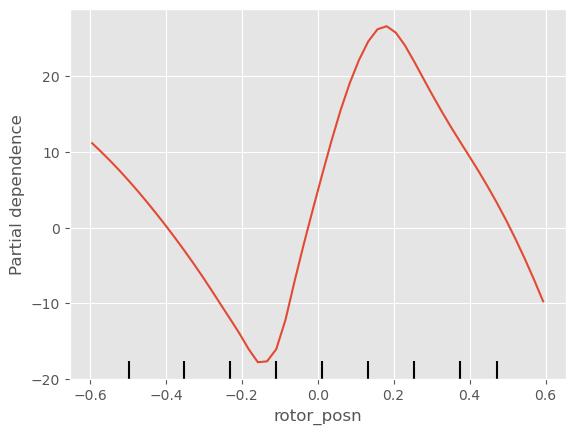

In [53]:
from sklearn.inspection import PartialDependenceDisplay

features = ['rotor_posn']
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

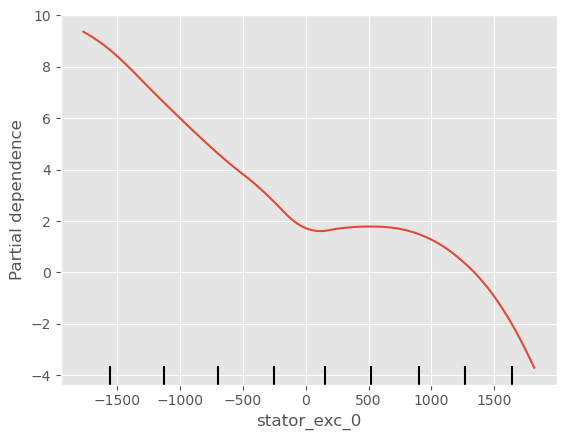

In [54]:
features = ['stator_exc_0']
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

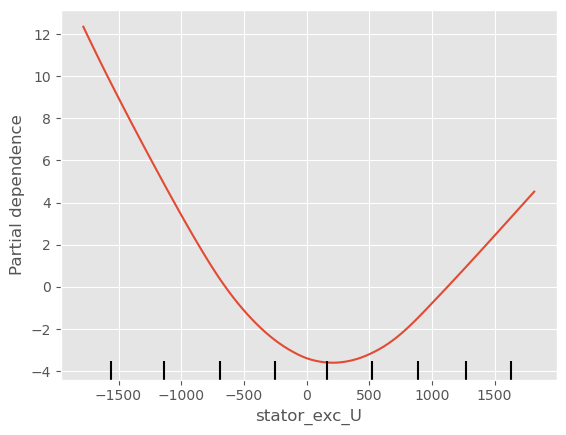

In [55]:
features = ['stator_exc_U']
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

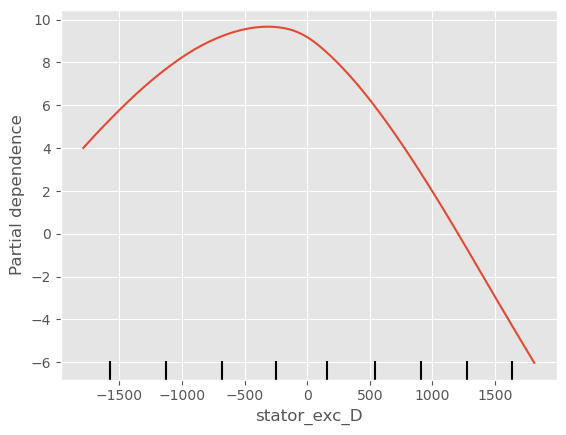

In [56]:
features = ['stator_exc_D']
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

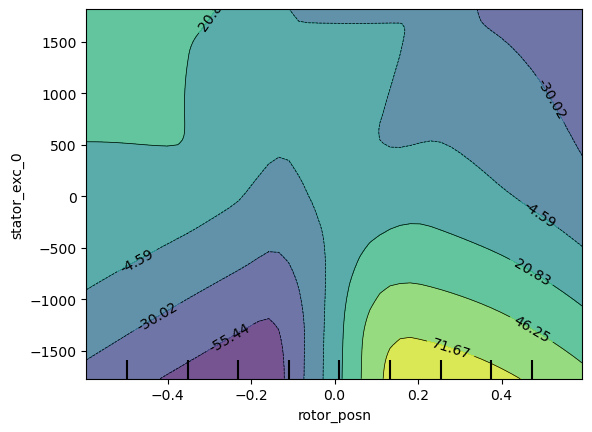

In [47]:
features = [('rotor_posn', 'stator_exc_0')]
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

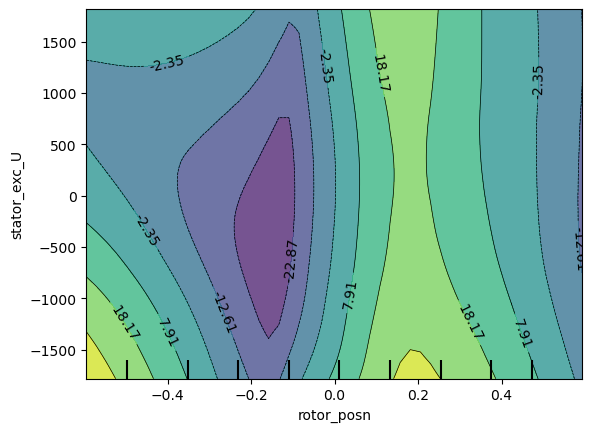

In [50]:
features = [('rotor_posn', 'stator_exc_U')]
PartialDependenceDisplay.from_estimator(mlp, X_train, features)

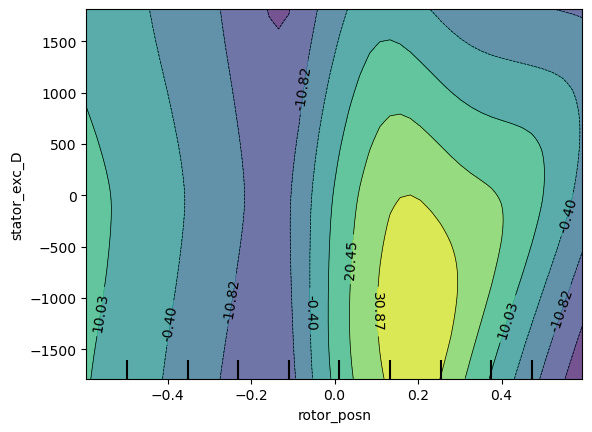

In [51]:
features = [('rotor_posn', 'stator_exc_D')]
PartialDependenceDisplay.from_estimator(mlp, X_train, features)